In [1]:
import numpy as np
import scipy
from scipy import optimize
from scipy import integrate
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# The Human Eye

The human eye has 3 different types of photoreceptor cells:
1. [Rod cells](https://en.wikipedia.org/wiki/Rod_cell), which function to detect brightness
2. [Cone cells](https://en.wikipedia.org/wiki/Cone_cell), which function to detect color
3. [Photosensitive Retinal Ganglion cells (pRGC)](https://en.wikipedia.org/wiki/Intrinsically_photosensitive_retinal_ganglion_cells), which are thought to influence the circadian rythm and a few other things.

Rod cells and pRGCs are thought to have little influence on color sensing of the human eye so we will not cover them here. Links above if you want to investigate further (obligatory Wikipedia black hole warning!!).

## Cone cells

The human eye has 3 different types of cones that have peaks of sensitivity in:
1. Short (S): 420 nm - 440 nm
2. Middle (M): 530 nm - 540 nm
3. Long (L): 560 nm - 580 nm

The full spectrums for the average human cone cells are shown below.
<img width="300" src="Cone-fundamentals-with-srgb-spectrum.png">

Commonly we talk about human vision being seen in red-green-blue (RGB) as correlated to the peaks of the cones responses; however, tying these to exact colors is very misleading as you can see that the "green" cone (M) can also see red wavelengths. Thus, researchers often prefer to refer to human vision as bing SML for the different cone types.
    
## Eye sensitivity

Before we start to talk about color in depth though, let's treat the eye as a single entity to understand its sensitivity to the electromagnetic spectrum as a whole. A great example of this is to take a look at the traditional incandescent bulb. Incandescent bulbs are often quoted as having extremely low efficiency, usually 2-5%; however, that is not the whole story!

First to get an understanding of the true efficiency of a light bulb we need to know the _spectral radiance_ of a standard bulb, which is defined as:

$L_{{{\mathrm  {e}},\Omega ,\lambda }}={\frac  {\partial L_{{{\mathrm  {e}},\Omega }}}{\partial \lambda }}$.

Here I found data for a GE 52 watt frosted bulb. 

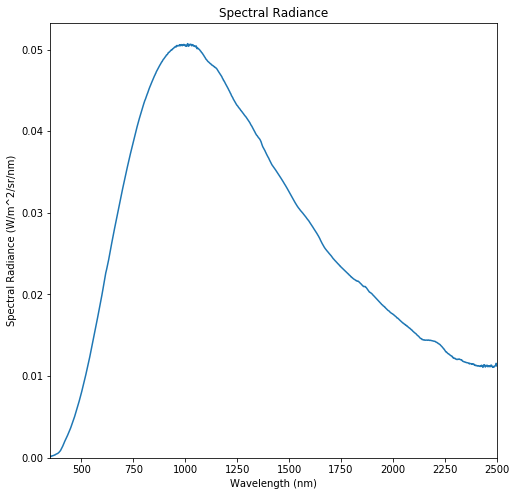

In [2]:
# Read in data
df = pd.read_csv('Incandescent_Lamps_20100311.csv', na_filter=False);
wavelength = df['Wavelength (nm)']
lamp = df['GE Wattmiser 52 W frosted']

# Show data
hfig = plt.figure(figsize=(8,8));
hax = plt.axes();
plt.plot(wavelength,lamp);
plt.title('Spectral Radiance');
plt.xlabel('Wavelength (nm)');
plt.ylabel('Spectral Radiance (W/m^2/sr/nm)');
plt.axis([np.amin(wavelength), np.amax(wavelength), 0, 1.05*np.amax(lamp)]);

Here you can see the spectral radiance covers a wide range of wavelengths looking to extend even beyond 2500 nm. It'd be nice if the group that took this data had taken it to a longer wavelength, but overall I'm not disappointed.

To make life a little bit cleaner for us I did some curve fitting (offline) to extend the spectrum out to 10 um.<br>
**Nerd note:**  _I used a log-normal distribution to match to this data using scipy's curvefit. The equation is:_<br>
$\frac{1}{x} \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(ln(x) - \mu)^2}{2\sigma^2}\right)$<br><br>
_Because I'm lazy, I introduced scaling factors A & B as:_<br><br>
$A\frac{1}{x} \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(ln(x - B) - \mu)^2}{2\sigma^2}\right)$<br>

A, B, mu, sigma: [ 88.79429322 300.61575913   6.8257705    0.65271271]


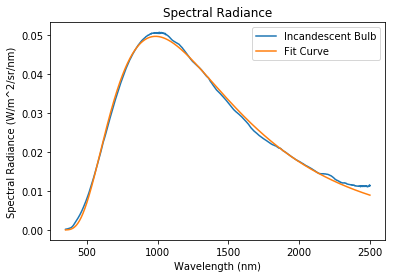

In [3]:
def lognorm(xin,A,B,mu,sigma):
    return A*1/xin * 1/sigma/np.sqrt(2*np.pi) * np.exp(-(np.log(xin-B) - mu)**2/2/sigma**2)

popt, pcov = optimize.curve_fit(lognorm,wavelength,lamp,p0=(200,250,7,.6))
print('A, B, mu, sigma:', popt)
plt.plot(wavelength,lamp);
plt.plot(wavelength,lognorm(wavelength, *popt));
plt.title('Spectral Radiance');
plt.xlabel('Wavelength (nm)');
plt.ylabel('Spectral Radiance (W/m^2/sr/nm)');
plt.legend(['Incandescent Bulb','Fit Curve']);

The data looks like a pretty good fit, but what does it look like extrapolated?

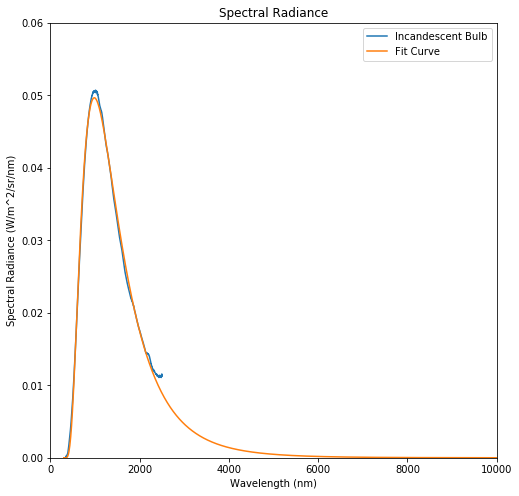

In [4]:
A     = 88.79429322;
B     = 300.6157591;
mu    = 6.8257705;
sigma = 0.65271271;
full_spectrum = np.linspace(np.ceil(B),10000,1001);
estimated_lamp = lognorm(full_spectrum,A,B,mu,sigma);
plt.figure(figsize=(8,8));
plt.plot(wavelength,lamp);
plt.plot(full_spectrum,estimated_lamp);
plt.title('Spectral Radiance');
plt.xlabel('Wavelength (nm)');
plt.ylabel('Spectral Radiance (W/m^2/sr/nm)');
plt.legend(['Incandescent Bulb','Fit Curve']);
plt.xlim([0,10000]);
plt.ylim([0, 0.06]);

Sanity check, does this make sense? It seems reasonable that the exponential looking taper at the high end would continue, but without the data we don't know. Let's keep digging.

You can see that the units on the y-axis are $W/m^2/sr/nm$ implying that we've got 3 levels of integration here to get to just a power value. Going back to the Wikipedia Radiance page we have:

$L_{{{\mathrm  {e}},\Omega, \lambda }}={\frac  {\partial ^{2}\Phi _{{\mathrm  {e}}}}{\partial \Omega \,\partial \lambda \,\partial A\cos \theta }}$

and

> When calculating the radiance emitted by a source, A refers to an area on the surface of the source, and Ω to the solid angle into which the light is emitted.

Just for gits and shiggles let's assume that our lightbulb is a GE 60A/52WM-130V which is pretty much your run of the mill lightbulb. It has a diameter of ~60.3 mm and we'll assume it radiates in all directions evenly. It also has an efficiency of 13.65 lumens per watt.

# [Radiant/Spectral Flux](https://en.wikipedia.org/wiki/Radiant_flux)

>In radiometry, radiant flux or radiant power is the radiant energy emitted, reflected, transmitted or received, per unit time, and spectral flux or spectral power is the radiant flux per unit frequency or wavelength, depending on whether the spectrum is taken as a function of frequency or of wavelength.

From [Radiance](https://en.wikipedia.org/wiki/Radiance)<br>
>When calculating the radiance emitted by a source, A refers to an area on the surface of the source, and Ω to the solid angle into which the light is emitted. When calculating radiance received by a detector, A refers to an area on the surface of the detector and Ω to the solid angle subtended by the source as viewed from that detector. When radiance is conserved, as discussed above, the radiance emitted by a source is the same as that received by a detector observing it.

Assumption 1: The lightbulb radiates evenly in all directions meaning we integrate across all 4 Pi sterradians.<br>
Assumption 2: The radiating source area is a sphere encapsulating the lightbulb filament.

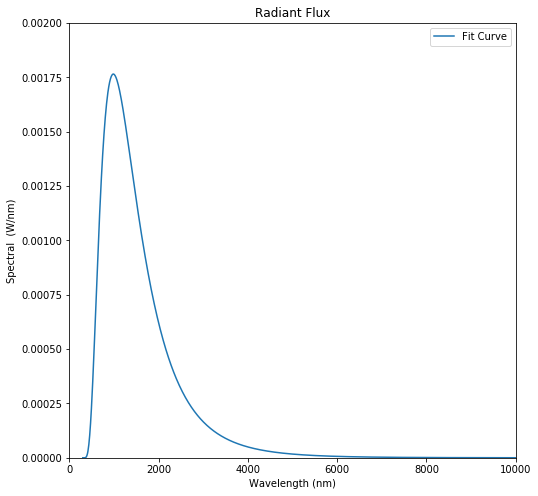

In [5]:
# "Integration" across a sphere
sr_sphere = 4*np.pi;
# Change spectral radiance to spectral flux density
spectral_flux_density = estimated_lamp * sr_sphere;

# Change spectral flux density to spectral_flux
filament_length = 30e-3;
area_sphere = sr_sphere * (filament_length/2)**2;
spectral_flux = spectral_flux_density * area_sphere;

# Plotting
plt.figure(figsize=(8,8));
plt.plot(full_spectrum,spectral_flux);
plt.title('Radiant Flux');
plt.xlabel('Wavelength (nm)');
plt.ylabel('Spectral  (W/nm)');
plt.legend(['Fit Curve']);
plt.axis([0,10000,0,0.002]);

In [6]:
# Integrate spectral flux to get radiant flux
total_radiant_flux = np.trapz(spectral_flux,full_spectrum)
print('Total broadband power that is radiated: {}'.format(total_radiant_flux))

Total broadband power that is radiated: 2.322191939762895


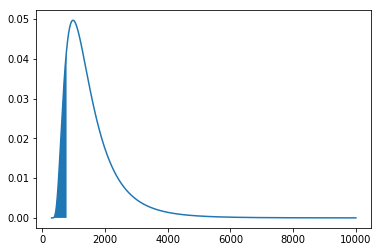

In [7]:
vis_min = 380;
vis_max = 780;
idx = (wavelength >= vis_min) & (wavelength <= vis_max)
plt.plot(full_spectrum,estimated_lamp)

plt.fill_between(wavelength[idx],lognorm(wavelength[idx], *popt))
# plt.xlim([300, 1000])

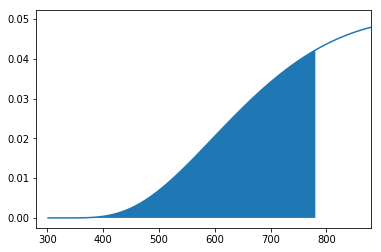

In [8]:

idx = (wavelength >= vis_min) & (wavelength <= vis_max)
plt.plot(full_spectrum,estimated_lamp)

plt.fill_between(wavelength[idx],lognorm(wavelength[idx], *popt))
plt.xlim([280, 880]);

In [9]:
vis_idx = (full_spectrum >= vis_min) & (full_spectrum <=vis_max);
vis_spectrum = full_spectrum[vis_idx];
vis_spectral_flux = spectral_flux[vis_idx];
# Integrate to get visible radiant flux
vis_radiant_flux = np.trapz(vis_spectral_flux,vis_spectrum)
print('Total visible power radiated: {}'.format(vis_radiant_flux))


Total visible power radiated: 0.2597472274186965


## [Human Sensitivity & Luminous Flux](https://en.wikipedia.org/wiki/Luminous_flux)

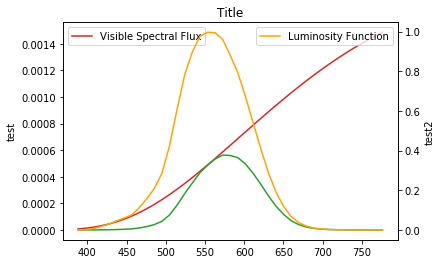

In [10]:
df = pd.read_csv('2deg_luminous_function.csv',names=['wave','amp'])
lum_fun = np.interp(vis_spectrum,df['wave'],df['amp'])
# Convert total spectral flux in visible spectrum to the luminous flux
vis_spectral_lum_flux = lum_fun * vis_spectral_flux;

fig, ax1 = plt.subplots()

color = 'tab:red'
h1 = ax1.plot(vis_spectrum,vis_spectral_flux,color=color,label='Visible Spectral Flux')

ax1.set_ylabel('test')
plt.legend()

ax2 = ax1.twinx()

h2 = ax2.plot(vis_spectrum, lum_fun,color='orange',label='Luminosity Function')
ax2.set_ylabel('test2')

plt.title('Title')
plt.legend()
color = 'tab:green';
h3 = ax1.plot(vis_spectrum,vis_spectral_lum_flux,color=color,label='Luminous Flux')

plt.legend()

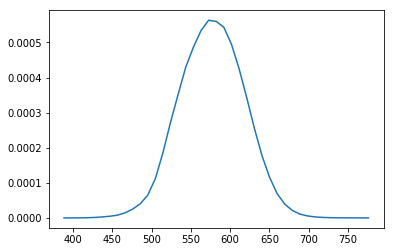

In [11]:
# Plot just the luminous flux from the light bulb
fig, ax1 = plt.subplots()
ax1.plot(vis_spectrum, vis_spectral_lum_flux);

In [12]:
vis_lum_flux = np.trapz(vis_spectral_lum_flux,vis_spectrum)
print('Total power seen by a person: {}'.format(vis_lum_flux))

watt2lumen = 683.002;
human_lum_flux = vis_lum_flux * watt2lumen
print('Total lumens seen by a person: {}'.format(human_lum_flux))

Total power seen by a person: 0.059838565919812375
Total lumens seen by a person: 40.86986020036369


In [13]:
print('Calculated Total Power Efficiency as %: ', 100 * total_radiant_flux / 52)
print('Calculated Human Visible Power Efficiency as %: ', 100 * vis_lum_flux / 52)
print('Expected Lumens per Watt: {0}'.format(710/52))
print('Calculated Lumens per Watt: {0}'.format(human_lum_flux/total_radiant_flux))


Calculated Total Power Efficiency as %:  4.46575373031326
Calculated Human Visible Power Efficiency as %:  0.11507416523040842
Expected Lumens per Watt: 13.653846153846153
Calculated Lumens per Watt: 17.599690835433982


## Wright-Guild color matching experiments
In the 1920's David Wright and John Guild each performed a series of experiments on human sight which laid the foundation for the specification of the CIE XYZ color space.

# The XYZ color matching functions

Originally, 

http://jcgt.org/published/0002/02/01/paper.pdf


In [14]:
def selector(x, y, z):
        return y * (1 - np.heaviside(x,0.5)) + z * np.heaviside(x,0.5)
    
def x_bar(wavelength):
    # Curve fitting constants from linked paper above
    alpha = np.array([0.362, 1.056, -0.065])
    beta  = np.array([442.0, 599.8, 501.1])
    gamma = np.array([0.0624, 0.0264, 0.0490])
    delta = np.array([0.0374, 0.0323, 0.0382])
    
    # Initialize x for summation
#     x = np.zeros(wavelength.shape)
    x = 0
    # Summation
    for nn in range(0,3):
        x = x + alpha[nn] * np.exp(-0.5 * ((wavelength - beta[nn]) * selector(wavelength - beta[nn],gamma[nn],delta[nn])) ** 2)
        
    return x

def y_bar(wavelength):
    # Curve fitting constants from linked paper above
    alpha = np.array([0.821, 0.286])
    beta  = np.array([568.8, 530.9])
    gamma = np.array([0.0213, 0.0613])
    delta = np.array([0.0247, 0.0322])

    # Initialize x for summation
#     x = np.zeros(wavelength.shape)
    x = 0
    # Summation
    for nn in range(0,2):
        x = x + alpha[nn] * np.exp(-0.5 * ((wavelength - beta[nn]) * selector(wavelength - beta[nn],gamma[nn],delta[nn])) ** 2)
        
    return x

def z_bar(wavelength):
    # Curve fitting constants from linked paper above
    alpha = np.array([1.217, 0.681])
    beta  = np.array([437.0, 459.0])
    gamma = np.array([0.0845, 0.0385])
    delta = np.array([0.0278, 0.0725])
    
    # Initialize x for summation
#     x = np.zeros(wavelength.shape)
    x = 0
    # Summation
    for nn in range(0,2):
        x = x + alpha[nn] * np.exp(-0.5 * ((wavelength - beta[nn]) * selector(wavelength - beta[nn],gamma[nn],delta[nn])) ** 2)
        
    return x

def cie_std_observer(wavelength):
    return x_bar(wavelength), y_bar(wavelength), z_bar(wavelength)

In [15]:
wv = np.linspace(380,780,101);
xx, yy, zz = cie_std_observer(wv);

rgb2xyz = np.array([[2.768, 1.751, 1.130],[1.000, 4.590, 0.060],[0.000, 0.056, 5.594]])
xyz2rgb = np.linalg.inv(rgb2xyz)

xyz_data = np.array([xx, yy, zz])
rgb_data = np.dot(xyz2rgb, xyz_data)
rr = rgb_data[0,:]
gg = rgb_data[1,:]
bb = rgb_data[2,:]

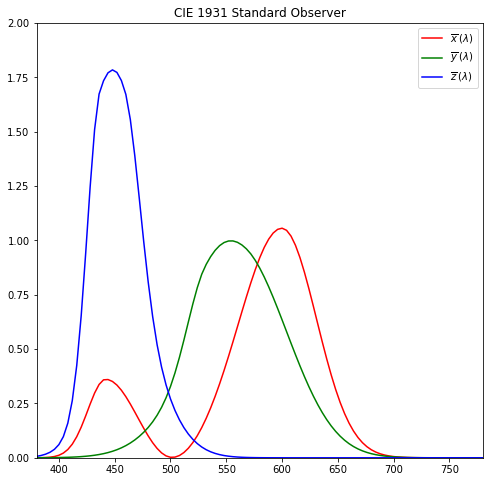

In [16]:
# %matplotlib notebook; %matplotlib notebook;
# %matplotlib inline
plt.figure(figsize=(8,8))
plt.plot(wv,xx,'r',label='$\overline{x}\;(\lambda)$')
plt.plot(wv,yy,'g',label='$\overline{y}\;(\lambda)$')
plt.plot(wv,zz,'b',label='$\overline{z}\;(\lambda)$')
plt.axis([np.amin(wv), np.amax(wv), 0.0, 2.0]);
plt.title('CIE 1931 Standard Observer')
plt.legend();

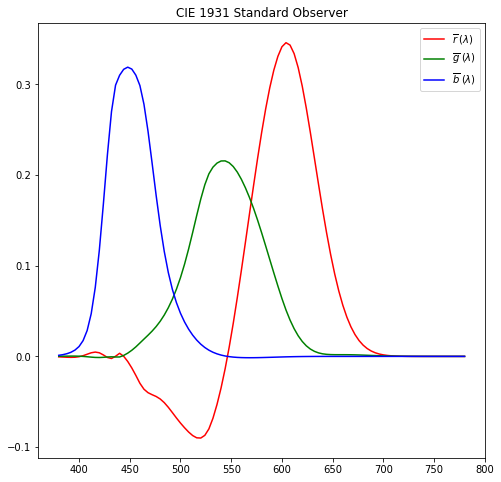

In [17]:
# %matplotlib notebook; %matplotlib notebook;
# %matplotlib inline
plt.figure(figsize=(8,8))
plt.plot(wv,rr,'r',label='$\overline{r}\;(\lambda)$')
plt.plot(wv,gg,'g',label='$\overline{g}\;(\lambda)$')
plt.plot(wv,bb,'b',label='$\overline{b}\;(\lambda)$')
# plt.axis([np.amin(wv), np.amax(wv), 0.0, 2.0]);
plt.title('CIE 1931 Standard Observer')
plt.legend();

In [18]:
r = np.linspace(0,1,101)/3
g = np.linspace(0,1,101)/3
b = np.linspace(0,1,101)/3


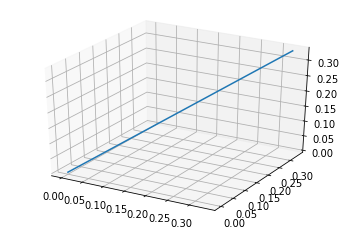

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(r,g,b)

# References
1. http://jamie-wong.com/post/color/
2. http://www.cvrl.org/
3. https://fluxometer.com/rainbow/#!id=lights/GE%20Incandescent&action=CIE1924Photopic
4. https://www.ngdc.noaa.gov/eog/spectra.html
5. https://www.ngdc.noaa.gov/eog/pubs/sensors-10-03961.pdf
6. https://en.wikipedia.org/wiki/Radiance
1. https://en.wikipedia.org/wiki/Radiative_flux
1. https://en.wikipedia.org/wiki/Intensity_(physics)
7. https://www.grainger.com/product/GE-LIGHTING-46-52-Watts-Incandescent-Lamp-1CWU7
8. https://www.reynoldsonline.com/ASSETS/DOCUMENTS/ITEMS/EN/GELA60A_52WM130V130_Spec.pdf